<a href="https://colab.research.google.com/github/deepakr82/AIML-Caps-Prj-Grp6-I-NLP/blob/master/NLP_Capstone_IT_Ticket_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##AIML Online Capstone - AUTOMATIC TICKET ASSIGNMENT

In [1]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
4/3wE3QojzrQZyz-SpjpwI0aGiAWPtlhuVEjGInxlh9Et6e92h_INC32U
Mounted at /content/drive/


# Load data and Pre-processing


In [1]:
import pandas as pd 
import numpy as np
import sys

In [44]:
# Read the .csv file
Ticket = pd.read_excel('/content/drive/My Drive/AIML/NLP/input_data.xlsx',encoding=sys.getfilesystemencoding())

In [45]:
Ticket.head()

,Short description,Description,Caller,Assignment group
0,login issue,-verified user details.(employee# & manager na...,spxjnwir pjlcoqds,GRP_0
1,outlook,\r\n\r\nreceived from: hmjdrvpb.komuaywn@gmail...,hmjdrvpb komuaywn,GRP_0
2,cant log in to vpn,\r\n\r\nreceived from: eylqgodm.ybqkwiam@gmail...,eylqgodm ybqkwiam,GRP_0
3,unable to access hr_tool page,unable to access hr_tool page,xbkucsvz gcpydteq,GRP_0
4,skype error,skype error,owlgqjme qhcozdfx,GRP_0


In [47]:
callers = Ticket['Caller'].unique() 
Ticket.drop(columns='Caller',inplace=True)
Ticket.head()

,Short description,Description,Assignment group
0,login issue,-verified user details.(employee# & manager na...,GRP_0
1,outlook,\r\n\r\nreceived from: hmjdrvpb.komuaywn@gmail...,GRP_0
2,cant log in to vpn,\r\n\r\nreceived from: eylqgodm.ybqkwiam@gmail...,GRP_0
3,unable to access hr_tool page,unable to access hr_tool page,GRP_0
4,skype error,skype error,GRP_0


In [48]:
Ticket.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8500 entries, 0 to 8499
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Short description  8492 non-null   object
 1   Description        8499 non-null   object
 2   Assignment group   8500 non-null   object
dtypes: object(3)
memory usage: 199.3+ KB


In [49]:
#Check for Null and drop null rows - Since null count is less
Ticket.isnull().sum()
Ticket.dropna(inplace=True)
Ticket.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8491 entries, 0 to 8499
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Short description  8491 non-null   object
 1   Description        8491 non-null   object
 2   Assignment group   8491 non-null   object
dtypes: object(3)
memory usage: 265.3+ KB


In [50]:
Ticket.describe()

,Short description,Description,Assignment group
count,8491,8491,8491
unique,7480,7812,74
top,password reset,the,GRP_0
freq,38,56,3968


In [51]:
TargetClass = Ticket['Assignment group'].value_counts()
TargetClass.describe()

count      74.000000
mean      114.743243
std       464.840614
min         1.000000
25%         5.250000
50%        26.000000
75%        84.000000
max      3968.000000
Name: Assignment group, dtype: float64

Observations:
1. There are 74 Groups in all. The Target class distribution is extremely skewed.
2. GRP_0 has the most number of assignments (3968) accounting for ~50% of the data.
3. There are some groups with 1 ticket assignment as well.

## Option 1 - Use data as is with some groups having less ticket assignments

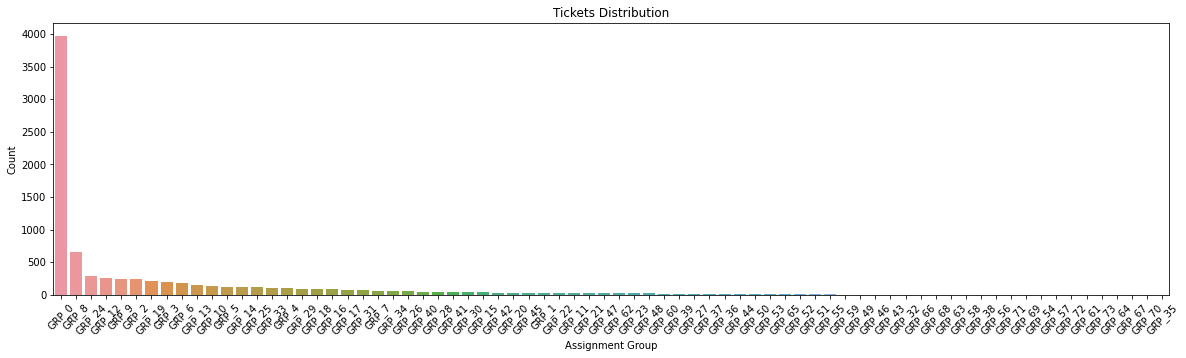

In [52]:
## Data Visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

plt.subplots(figsize = (20,5))

sns.countplot(x='Assignment group', data=Ticket,order = Ticket['Assignment group'].value_counts().index)
plt.xlabel('Assignment Group') 
plt.ylabel('Count') 
plt.xticks(rotation=45)
plt.title('Tickets Distribution')

plt.show()

## Option 2 -  Merge groups with small entries to a group to reduce the imbalance in the target class.

In [53]:
# Group the tickets count < 100 as GRP_A
Ticket1 = pd.DataFrame(Ticket['Assignment group'].value_counts())
Ticket1 = Ticket1.T
Ticket1

,GRP_0,GRP_8,GRP_24,GRP_12,GRP_9,GRP_2,GRP_19,GRP_3,GRP_6,GRP_13,GRP_10,GRP_5,GRP_14,GRP_25,GRP_33,GRP_4,GRP_29,GRP_18,GRP_16,GRP_17,GRP_31,GRP_7,GRP_34,GRP_26,GRP_40,GRP_28,GRP_41,GRP_30,GRP_15,GRP_42,GRP_20,GRP_45,GRP_1,GRP_22,GRP_11,GRP_21,GRP_47,GRP_62,GRP_23,GRP_48,GRP_60,GRP_39,GRP_27,GRP_37,GRP_36,GRP_44,GRP_50,GRP_53,GRP_65,GRP_52,GRP_51,GRP_55,GRP_59,GRP_49,GRP_46,GRP_43,GRP_32,GRP_66,GRP_68,GRP_63,GRP_58,GRP_38,GRP_56,GRP_71,GRP_69,GRP_54,GRP_57,GRP_72,GRP_61,GRP_73,GRP_64,GRP_67,GRP_70,GRP_35
Assignment group,3968,661,289,257,252,241,215,200,184,145,140,129,118,116,107,100,97,88,85,81,69,68,61,56,45,44,40,39,39,37,36,35,31,31,30,29,27,25,25,25,20,19,18,16,15,15,14,11,11,9,8,8,6,6,6,5,4,4,3,3,3,3,3,2,2,2,2,2,1,1,1,1,1,1


In [54]:
Ticket['Count'] = Ticket.apply(lambda row: Ticket1[row['Assignment group']] , axis=1)
Ticket.loc[Ticket['Count'] <= 100 , "Assignment group"] = "GRP_A"

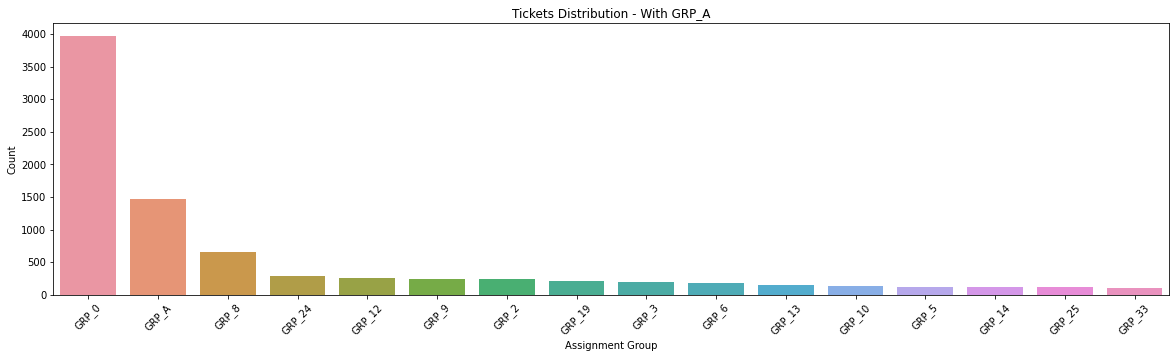

In [55]:
plt.subplots(figsize = (20,5))

sns.countplot(x='Assignment group', data=Ticket,order = Ticket['Assignment group'].value_counts().index)
plt.xlabel('Assignment Group') 
plt.ylabel('Count') 
plt.xticks(rotation=45)
plt.title('Tickets Distribution - With GRP_A')

plt.show()

Merge "Short description"and "Description" column

In [56]:
Ticket['Description'] = Ticket['Short description'] + ' '+ Ticket['Description']
Ticket.drop(columns=['Short description','Count'],inplace=True)
Ticket.head()

,Description,Assignment group
0,login issue -verified user details.(employee# ...,GRP_0
1,outlook \r\n\r\nreceived from: hmjdrvpb.komuay...,GRP_0
2,cant log in to vpn \r\n\r\nreceived from: eylq...,GRP_0
3,unable to access hr_tool page unable to access...,GRP_0
4,skype error skype error,GRP_0


# Data Cleansing

Now, need to cleanup the data, so that we can do text classification. So for this certain actions needed :

Convert the entire text in lower case
Remove HTML tags
Remove stopwords
Remove punctuations, special characters, numbers

In [57]:
# Define a function to clean the data
import re
from dateutil import parser
def is_valid_date(date_str):
    try:
        parser.parse(date_str)
        return True
    except:
        return False
        
def clean_data(text):
    text = text.lower()
    text = ' '.join([w for w in text.split() if not is_valid_date(w)])
    text = re.sub(r"received from:",' ',text)
    text = re.sub(r"from:",' ',text)
    text = re.sub(r"to:",' ',text)
    text = re.sub(r"subject:",' ',text)
    text = re.sub(r"sent:",' ',text)
    text = re.sub(r"ic:",' ',text)
    text = re.sub(r"cc:",' ',text)
    text = re.sub(r"bcc:",' ',text)
    #Remove email 
    text = re.sub(r'\S*@\S*\s?', '', text)
    # Remove numbers 
    text = re.sub(r'\d+','' ,text)
    # Remove new line characters 
    text = re.sub(r'\n',' ',text)
    # Remove hashtag while keeping hashtag text
    text = re.sub(r'#','', text)
    text = re.sub(r'&;?', 'and',text)
    # Remove HTML special entities (e.g. &amp;)
    text = re.sub(r'\&\w*;', '', text)
    # Remove hyperlinks
    text = re.sub(r'https?:\/\/.*\/\w*', '', text)  
    # Remove characters beyond Readable formart by Unicode:
    text= ''.join(c for c in text if c <= '\uFFFF') 
    text = text.strip()
    # Remove unreadable characters  (also extra spaces)
    text = ' '.join(re.sub("[^\u0030-\u0039\u0041-\u005a\u0061-\u007a]", " ", text).split())
    for name in callers:
      namelist = [part for part in name.split()]
      for namepart in namelist: 
          text = text.replace(namepart,'')
          
    text = re.sub(r"\s+[a-zA-Z]\s+", ' ', text)
    text = re.sub(' +', ' ', text)
    text = text.strip()
    return text

In [58]:
Ticket['Description'] = Ticket['Description'].apply(clean_data)

In [59]:
Ticket.head()

,Description,Assignment group
0,login issue verified user details employee and...,GRP_0
1,outlook hello team my meetings skype meetings ...,GRP_0
2,cant log in to vpn hi cannot log on to vpn best,GRP_0
3,unable to access hr tool page unable to access...,GRP_0
4,skype error skype error,GRP_0



Lemmatisation and stop words removal

In [62]:
from nltk.corpus import stopwords
import nltk
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger') 

stop = stopwords.words('english')
for i,text in enumerate(Ticket['Description']):
 Ticket['Description'][i]=" ".join(word for word in text.split(' ') if word not in stop)

import spacy
nlp = spacy.load('en', disable=['parser', 'ner'])
allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']
def lemmatize_text(text):
    doc = nlp(text)
    return ' '.join([token.lemma_ for token in doc])

Ticket['Description'] = Ticket['Description'].apply(lemmatize_text)

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [63]:
Ticket.head()

,Description,Assignment group
0,login issue verify user detail employee manage...,GRP_0
1,outlook hello team meeting skype meeting etc a...,GRP_0
2,can not log vpn hi can not log vpn best,GRP_0
3,unable access hr tool page unable access hr to...,GRP_0
4,skype error skype error,GRP_0


In [64]:
combined_text = Ticket.Description.values.tolist()

In [65]:
combined_text[1]

'outlook hello team meeting skype meeting etc appear outlook calendar somebody please advise correct kind'

In [66]:
# Tokenize
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models.ldamodel import LdaModel
from gensim.models import CoherenceModel
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(combined_text))

In [67]:
data_words[1]

['outlook',
 'hello',
 'team',
 'meeting',
 'skype',
 'meeting',
 'etc',
 'appear',
 'outlook',
 'calendar',
 'somebody',
 'please',
 'advise',
 'correct',
 'kind']

In [68]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100)
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)

bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

/usr/local/lib/python3.6/dist-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


In [69]:
bigram_mod[data_words[1]]

['outlook',
 'hello',
 'team',
 'meeting',
 'skype',
 'meeting',
 'etc',
 'appear',
 'outlook',
 'calendar',
 'somebody',
 'please',
 'advise',
 'correct',
 'kind']

In [70]:
trigram_mod[data_words[1]]

['outlook',
 'hello',
 'team',
 'meeting',
 'skype',
 'meeting',
 'etc',
 'appear',
 'outlook',
 'calendar',
 'somebody',
 'please',
 'advise',
 'correct',
 'kind']

In [71]:
def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

In [72]:
data_words_bigrams = make_bigrams(data_words)

In [73]:
Ticket_new = Ticket.copy()
Ticket_new['words'] = data_words_bigrams
Ticket_new.head()

,Description,Assignment group,words
0,login issue verify user detail employee manage...,GRP_0,"[login, issue, verify, user, detail, employee,..."
1,outlook hello team meeting skype meeting etc a...,GRP_0,"[outlook, hello, team, meeting, skype, meeting..."
2,can not log vpn hi can not log vpn best,GRP_0,"[can_not, log, vpn, hi, can_not, log, vpn, best]"
3,unable access hr tool page unable access hr to...,GRP_0,"[unable, access, hr, tool, page, unable, acces..."
4,skype error skype error,GRP_0,"[skype, error, skype, error]"


In [74]:
value = Ticket_new['Assignment group'].value_counts().sort_values(ascending=False).index
value

Index(['GRP_0', 'GRP_A', 'GRP_8', 'GRP_24', 'GRP_12', 'GRP_9', 'GRP_2',
       'GRP_19', 'GRP_3', 'GRP_6', 'GRP_13', 'GRP_10', 'GRP_5', 'GRP_14',
       'GRP_25', 'GRP_33'],
      dtype='object')

In [75]:
from wordcloud import WordCloud
# Creating a function for wordcloud
def wordcloud_grp(f, x):
    wordclouds_0=' '.join(map(str, f))

    wc = WordCloud(width=480, height=480, max_font_size=20, min_font_size=10, max_words=100).generate(wordclouds_0)
    plt.figure(figsize=(20,10))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title("Most common 100 words of {}".format(x))
    plt.margins(x=0, y=0)
    plt.show()

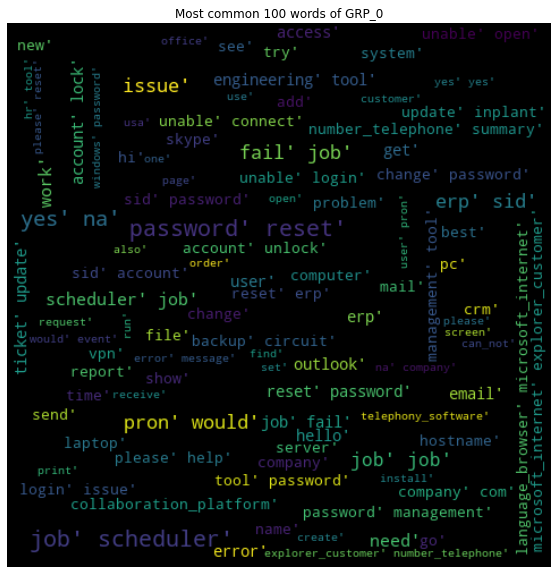

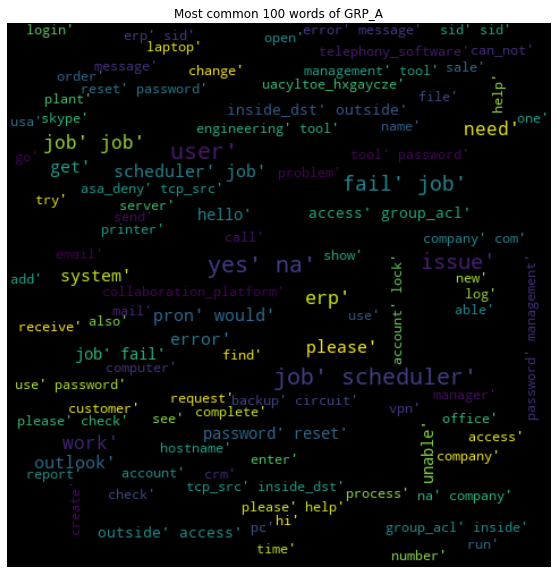

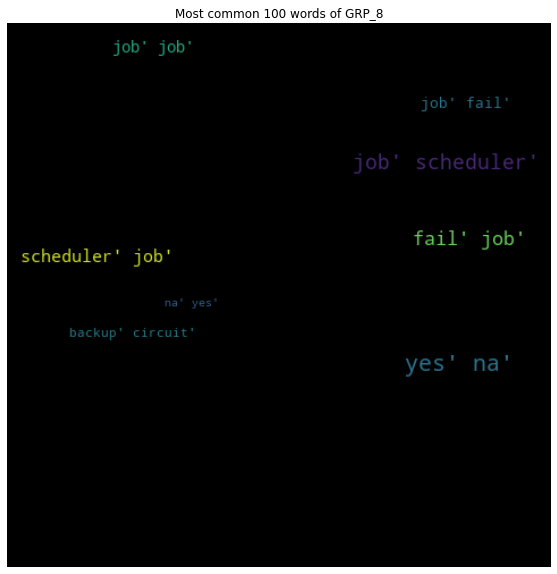

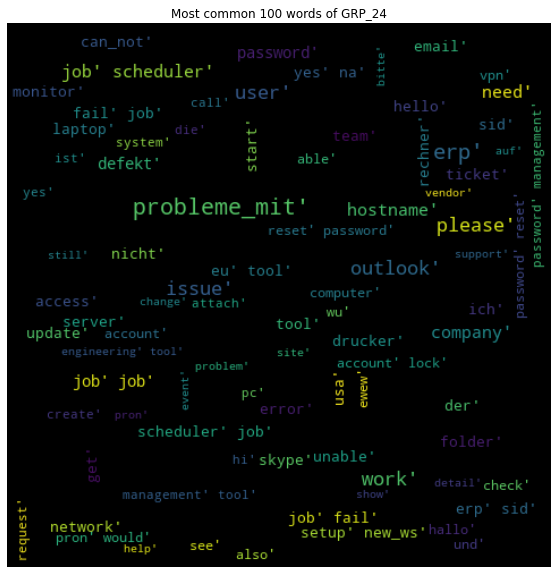

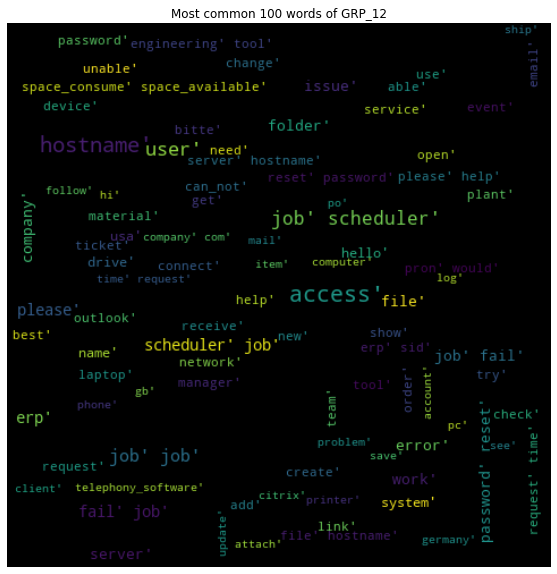

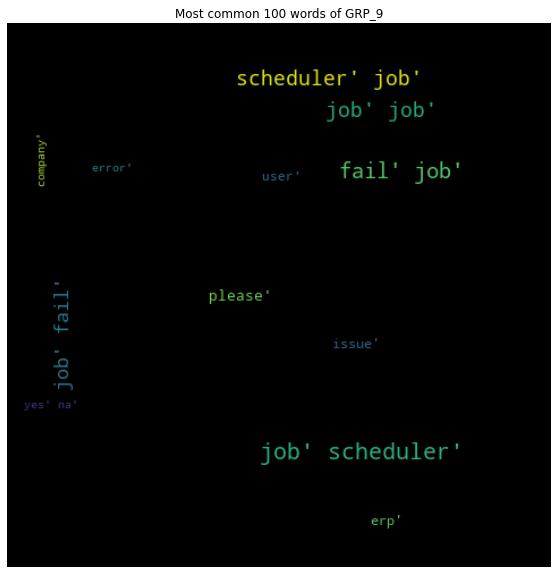

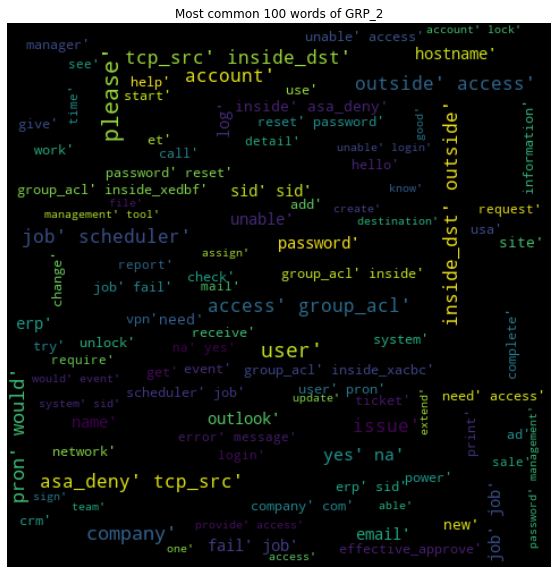

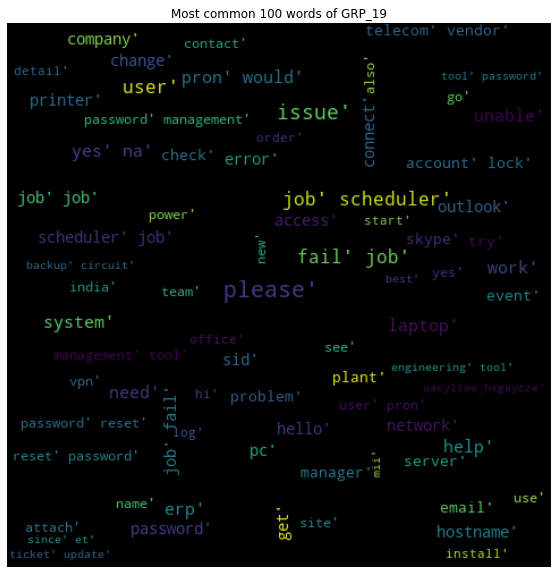

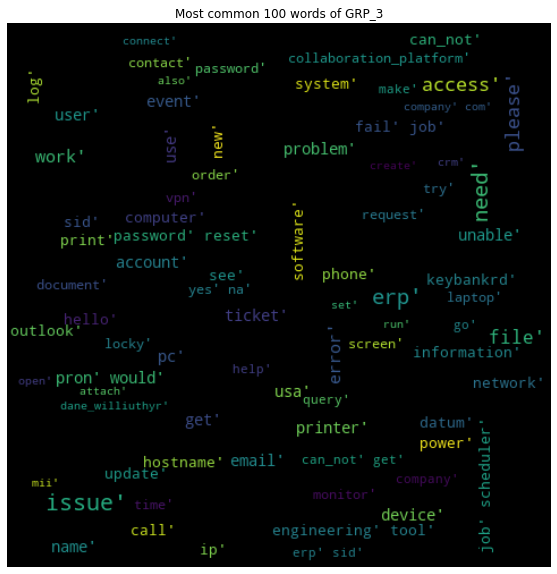

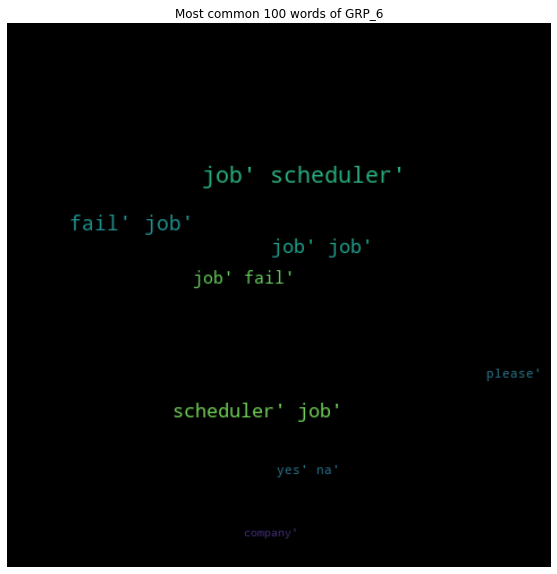

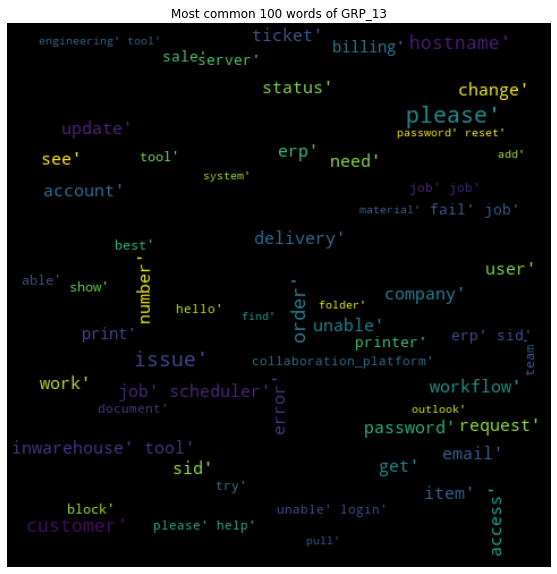

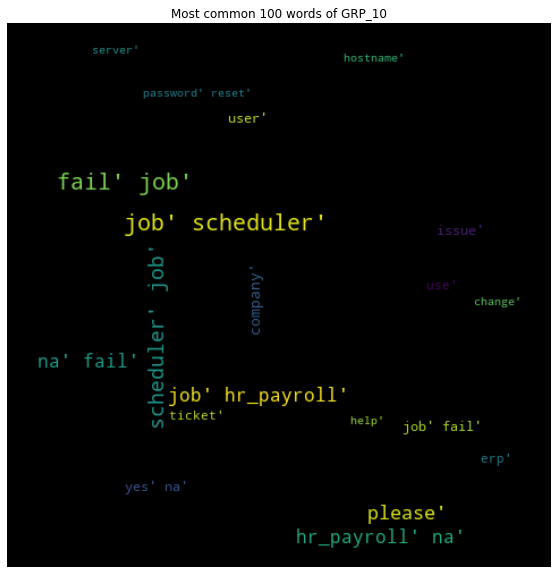

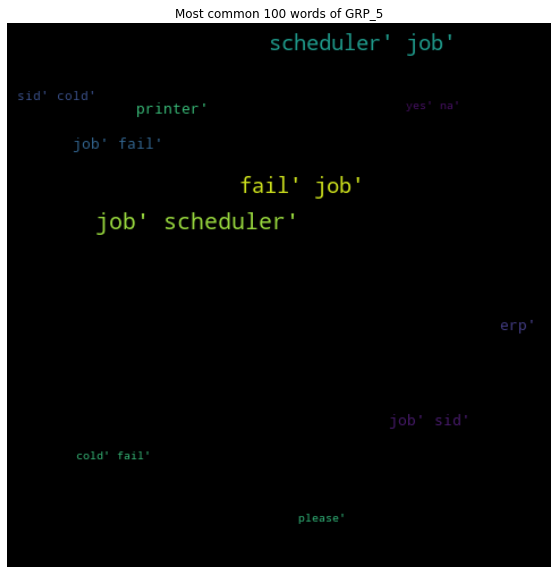

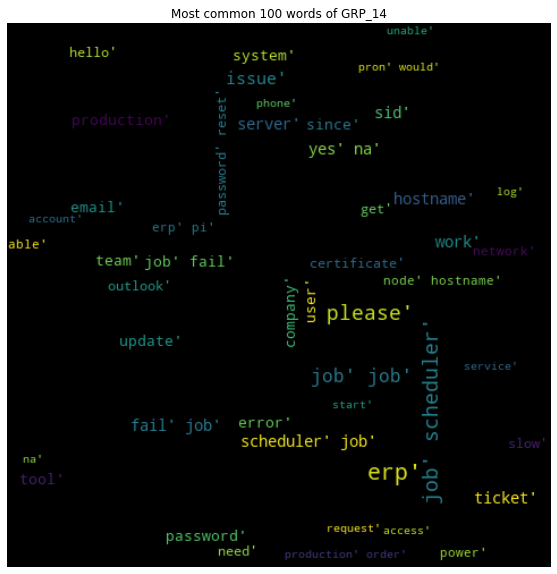

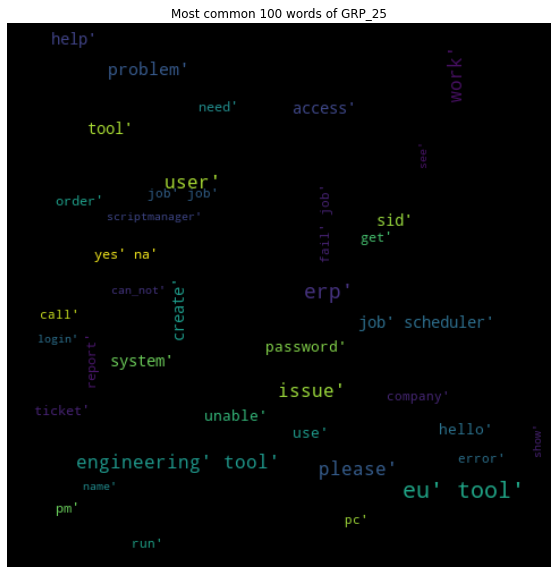

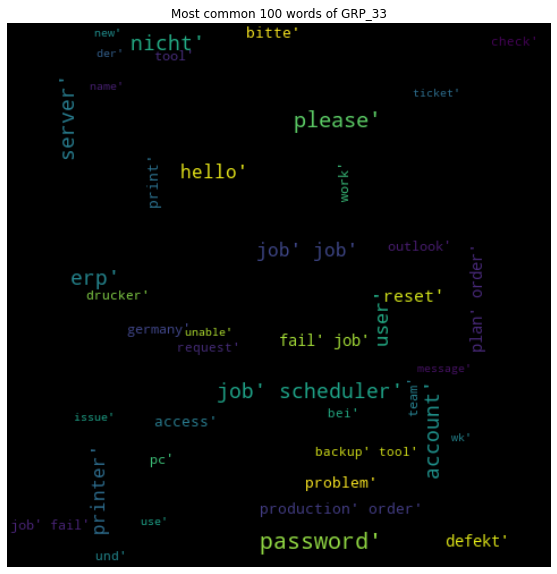

In [76]:
for i in range(16):
    Grp = Ticket_new[Ticket_new ['Assignment group'] == value[i]]
    Grp = Grp['words']
    wordcloud_grp(Grp,value[i])